In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
from datetime import datetime, timedelta
from scipy.optimize import brentq
from tqdm import tqdm # actually makes it slower but its nice to have
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import SmoothBivariateSpline
from pygam import LinearGAM, s, te
from scipy.stats import ttest_1samp

In [2]:
ticker = "SPY"
yf_ticker = yf.Ticker(ticker)

In [3]:
def black_scholes(sigma, S, K, t, r, option_type="call"):
    if option_type not in ["call", "put"]:
        raise ValueError("option_type must be 'call' or 'put'")
    if t <= 0 or sigma <= 0:
        raise ValueError("Time to maturity and volatility must be positive.")

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    if option_type == "call":
        price = (S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2))
    else:
        price = (K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return price

def obj(sigma, market_price, S, K, t, r, option_type="call"):
    model_price = black_scholes(sigma, S, K, t, r, option_type)
    return model_price - market_price

In [4]:
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
def get_dte(option):
    date_str = option["contractSymbol"].split(ticker)[1].split("C" if option["type"] == "call" else "P")[0] # yymmdd
    expiration_date = datetime.strptime(date_str, "%y%m%d")
    dte = (expiration_date - today).days
    return dte

In [5]:
rf_rates = { #https://tradingeconomics.com/united-states/government-bond-yield
    30: 4.19 / 100, # 1 month treasury yield
    60: 4.42 / 100, # 2 month treasury yield
    90: 4.36 / 100, # 3 month treasury yield
    180: 4.30 / 100, # 6 month treasury yield
    365: 4.10 / 100, # 1 year treasury yield
    730: 3.96 / 100, # 2 year treasury yield
    1095: 3.92 / 100, # 3 year treasury yield
    1825: 4.02 / 100
}

In [6]:
# get continuously compounded dividend yield
def get_dividend_yield(ticker):
    try:
        dividend_yield = yf_ticker.info['dividendYield']
        if dividend_yield is None:
            return 0.0
        return dividend_yield
    except KeyError:
        return 0.0

dividend_yield = get_dividend_yield(ticker)
dividend_yield

1.21

In [7]:
S = yf_ticker.history(period="1d").iloc[-1]["Close"]
q = yf_ticker.info["dividendYield"]

results = []

counter = 0

for date_str in tqdm(yf_ticker.options):
    calls = yf_ticker.option_chain(date_str).calls
    puts = yf_ticker.option_chain(date_str).puts

    calls['type'] = 'call'
    puts['type'] = 'put'

    all_options = pd.concat([calls, puts], ignore_index=True)
    dte = get_dte(all_options.iloc[0])  # Get DTE from the first option - should all be the same for a given date_str
    t = dte / 365 # Convert DTE to years
    
    if dte <= 0:
        continue

    for rf_dte in sorted(rf_rates.keys()):
        if dte <= rf_dte:
            r = rf_rates[rf_dte]
            break

    for i, option in all_options.iterrows():
        counter += 1

        K = option["strike"]
        market_price = option["lastPrice"]
        forward_price = S * np.exp((r - q) * t)

        try:
            sigma = brentq(obj, 1e-6, 5, args=(market_price, S, K, t, r, option["type"]), xtol=1e-6)
        except ValueError:
            continue
        
        bs_price = black_scholes(sigma, S, K, t, r, option["type"])

        results.append({
            "strike": K,
            "dte": dte,
            "type": option["type"],
            "iv": sigma,
            "market_price": market_price,
            "forward_price": forward_price,
            "bs_price": bs_price,
        })

len(results), counter

100%|██████████| 31/31 [00:18<00:00,  1.71it/s]


(5975, 6883)

In [8]:
results_df = pd.DataFrame(results)
results_df.head()

,strike,dte,type,iv,market_price,forward_price,bs_price
0,505.0,3,call,1.624152,99.22,593.435796,99.219998
1,545.0,3,call,0.712461,55.50,593.435796,55.499999
2,555.0,3,call,0.903963,48.77,593.435796,48.770000
3,562.0,3,call,0.629234,39.50,593.435796,39.500000
4,563.0,3,call,0.471065,37.14,593.435796,37.139998


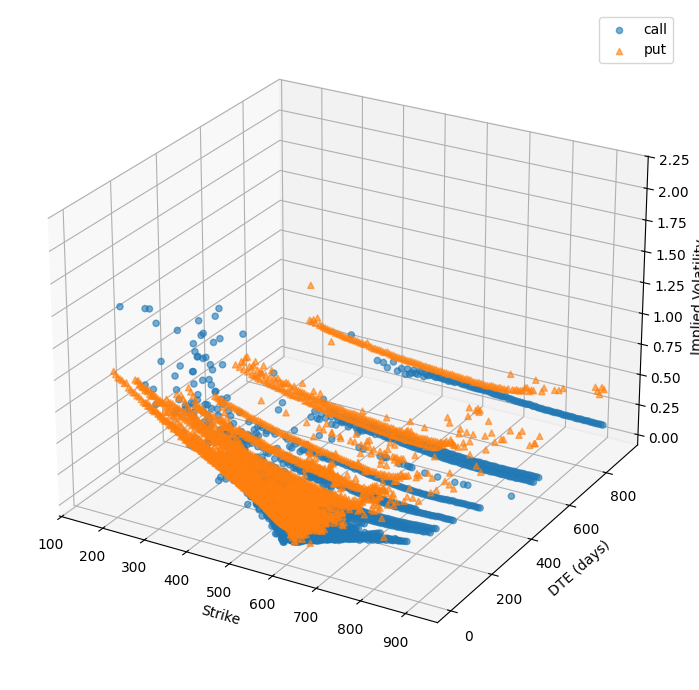

In [9]:
fig = plt.figure(figsize=(10, 7))
ax  = fig.add_subplot(111, projection='3d')

for option_type, marker in [("call", "o"), ("put", "^")]:
    sub = results_df[results_df["type"] == option_type]
    ax.scatter(
        sub["strike"],
        sub["dte"],
        sub["iv"],
        marker=marker,
        label= option_type,
        alpha=0.6
    )

ax.set_xlabel("Strike")
ax.set_ylabel("DTE (days)")
ax.set_zlabel("Implied Volatility")



ax.view_init(elev=25, azim=-60)   # adjust angle to taste
ax.legend()
plt.tight_layout()
plt.show()

## Transform axis  
#### Log moneyness: $m = \ln\frac KF$, K = strike, F = implied forward price today  
#### Time: $\tau = \sqrt{\frac{\text{DTE}}{365}}$, annualised with 365 calendar days (FX) or 252 trading days (Equities)

In [10]:
results_df["moneyness"] = np.log(results_df["strike"] / results_df["forward_price"])
results_df["time"] = np.sqrt(results_df["dte"] / 365)

calls = results_df[results_df["type"] == "call"].copy()
puts = results_df[results_df["type"] == "put"].copy()

calls.head()

,strike,dte,type,iv,market_price,forward_price,bs_price,moneyness,time
0,505.0,3,call,1.624152,99.22,593.435796,99.219998,-0.161371,0.09066
1,545.0,3,call,0.712461,55.50,593.435796,55.499999,-0.085143,0.09066
2,555.0,3,call,0.903963,48.77,593.435796,48.770000,-0.066961,0.09066
3,562.0,3,call,0.629234,39.50,593.435796,39.500000,-0.054427,0.09066
4,563.0,3,call,0.471065,37.14,593.435796,37.139998,-0.052649,0.09066


In [11]:
# Fit seperate calls and puts then investigate if there are differences

def fit_spline(df):
    x = df["moneyness"].values
    y = df["time"].values
    z = df["iv"].values

    s = len(df) * np.var(df["iv"])

    # Create a smooth bivariate spline
    spline = SmoothBivariateSpline(x, y, z, s=s)
    
    return spline

call_spline = fit_spline(calls)
put_spline = fit_spline(puts)

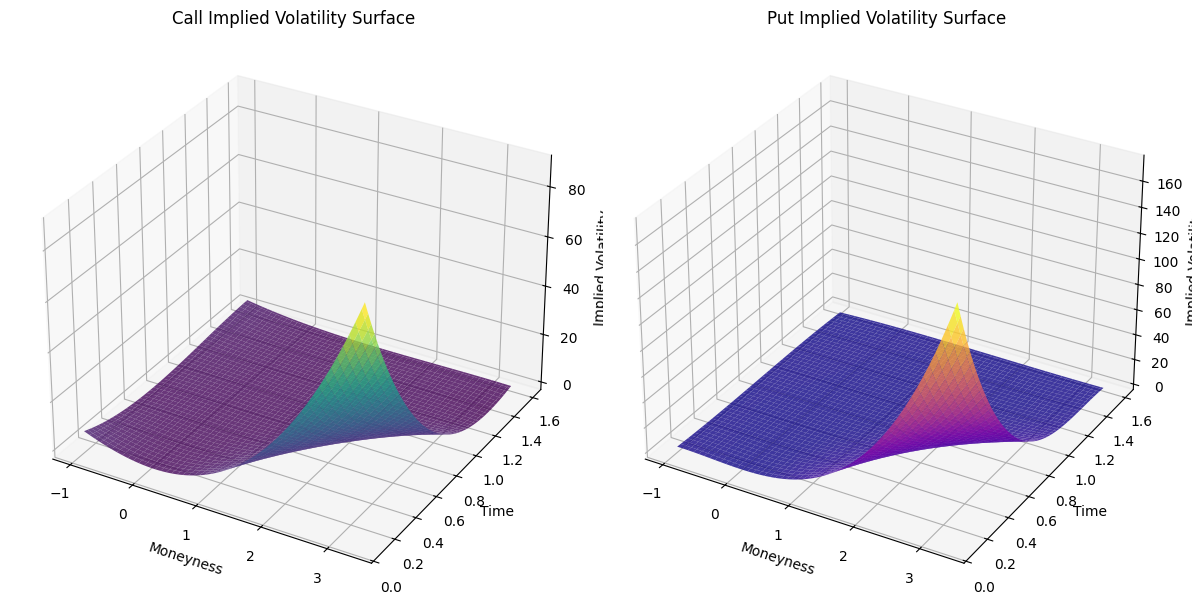

In [12]:
m_min, m_max = calls["moneyness"].min(), calls["moneyness"].max()
t_min, t_max = calls["time"].min(), calls["time"].max()

m_grid = np.linspace(m_min, m_max, 100)
t_grid = np.linspace(t_min, t_max, 100)
M, T = np.meshgrid(m_grid, t_grid)

Z_calls = call_spline.ev(M.ravel(), T.ravel()).reshape(M.shape)
Z_puts = put_spline.ev(M.ravel(), T.ravel()).reshape(M.shape)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(M, T, Z_calls, cmap='viridis', alpha=0.8)
ax1.set_title("Call Implied Volatility Surface")
ax1.set_xlabel("Moneyness")
ax1.set_ylabel("Time")
ax1.set_zlabel("Implied Volatility")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(M, T, Z_puts, cmap='plasma', alpha=0.8)
ax2.set_title("Put Implied Volatility Surface")
ax2.set_xlabel("Moneyness")
ax2.set_ylabel("Time")
ax2.set_zlabel("Implied Volatility")

plt.tight_layout()
plt.show()

Spikes at the corners - expected result of using B splines

$H_0: \sigma_{call}(m_i, \tau_i) = \sigma_{put}(m_i, \tau_i)$

In [13]:
delta = Z_calls - Z_puts
t_stat, p_val = ttest_1samp(delta.ravel(), 0)

print(f"Delta Mean: {np.mean(delta):.4f}, T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")

Delta Mean: -3.4528, T-statistic: -37.4303, P-value: 0.0000


Rejected $H_0$